# PROJET MACHINE LEARNING (STEP 1) - MATHIEU COWAN, ALARIC DE BASTARD, ADRIEN DE MAILLY NESLE (DIA 3)

## IMPORTATION ET LOAD

In [5]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

C:\Users\ime cj\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
df1 = pd.read_csv("Online_Retail.csv", sep=';', encoding='ISO-8859-1')

## DATA PREPROCESSING

In [8]:
# Creation de colonnes Day, Hour, Week, Month à partir de l'invoice date pour une manipulation plus aisée

df1['Day'] = df1['InvoiceDate'].str.split(' ').str[0]
df1['Hour'] = df1['InvoiceDate'].str.split(' ').str[1]
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], dayfirst=True)
df1['Day'] = pd.to_datetime(df1['Day'], dayfirst=True)
df1['Hour'] = pd.to_datetime(df1['Hour'], format='%H:%M')
df1['Hour'] = df1['Hour'].dt.hour
df1['Week'] = df1['InvoiceDate'].dt.isocalendar().week
df1['Month'] = df1['InvoiceDate'].dt.to_period('M')

In [9]:
# Cast de la colonne 'UnitPrice' en float
# Creation de la colonne 'Total' qui correspond à la multiplication de la quantité par le prix unitaire

df1['UnitPrice'] = df1['UnitPrice'].str.replace(',', '.').astype(float)
df1[df1['UnitPrice'] < 0]
df1['Total'] = df1['Quantity'] * df1['UnitPrice']

In [10]:
# Data cleaning: 
# suppression des lignes à descriptions non renseignés
# suppression des lignes de transactions annulées (C)
# suppression des lignes avec un prix négatif ou un prix trop grand (valeurs aberrantes)
# suppression des lignes avec une quantité négative
# suppression des transactions d'article qui n'apparaît qu'une fois
# suppression des doublons
# remplacement des virgules par des espaces dans les descriptions (pour la création de la colonne common description)

df1 = df1[df1['Description'].notnull()]
df1 = df1[df1['InvoiceNo'].str[0] != 'C']
df1 = df1[(df1['UnitPrice'] < 1000) & (df1['UnitPrice'] >0)]
df1 = df1[df1['Quantity']>0]
description_counts = df1['Description'].value_counts()
descriptions_to_keep = description_counts[description_counts > 1].index
df1 = df1[df1['Description'].isin(descriptions_to_keep)]
df1 = df1.drop_duplicates()
df1['Description'] = df1['Description'].replace(',', ' ', regex=True)

In [11]:
# Transformation des valeurs non renseignés en -1 pour la colonne CustomerID

df1['CustomerID'] = df1['CustomerID'].fillna(-1)
df1['CustomerID'] = df1['CustomerID'].astype(int)

## EXPLORATION DATA ET COMMON DESCRIPTION

In [13]:
# Creation d'une nouvelle colonne BaseStockCode en supprimant les lettres finales de StockCode

df1['BaseStockCode'] = df1['StockCode'].str.extract(r'(\d+)')
df1['Description'] = df1['Description'].fillna('')

# Creation d'un dictionnaire qui associera chaque BaseStockCode a une description commune
base_stockcode_to_description = {}

# Fonction qui prend une liste de descriptions et retourne les mots communs aux descriptions
def common_words(descriptions):
    words_list = [set(desc.split()) for desc in descriptions]
    common_words_set = set.intersection(*words_list) if words_list else set()
    return ' '.join(common_words_set)

# Regroupe les articles par BaseStockCode et applique la fonction a chaque groupe
common_descriptions = df1.groupby('BaseStockCode')['Description'].apply(common_words).to_dict()

# Mise à jour du dictionnaire base_stockcode_to_description
base_stockcode_to_description.update(common_descriptions)

# Map le BaseStockCode à la description commune
df1['CommonDescription'] = df1['BaseStockCode'].map(base_stockcode_to_description)

# Si la description commune est vide, on la remplace par la description de base
df1['CommonDescription'] = df1['CommonDescription'].fillna(df1['Description'])

#print(df1[['StockCode', 'Description', 'BaseStockCode', 'CommonDescription']])


In [14]:
# Quelques explorations de données pour comprendre le dataset et les erreurs potentielles

df1[df1['StockCode']==r"D"]
df1[(df1['StockCode'].fillna('').str.contains(r'16156')) & (~df1['Description'].str.contains('WRAP'))]
df1.loc[df1['Description'].fillna('').str.islower(), ['Description', 'Quantity']]
df1[df1["StockCode"]=="47566"]["Description"].unique()
df1.loc[df1['StockCode'].fillna('').str.contains(r'D')]
df1.loc[(df1['CustomerID'] == 14527) & (df1['UnitPrice'] == 27.5)]
df1['CustomerID'].isnull().sum()
df1.iloc[299980:300000]
df1.loc[~df1['InvoiceNo'].str.contains('C')].iloc[140:150]
df1.loc[~df1['InvoiceNo'].str.contains('C') & (df1['Quantity']<0) & (df1['Description'].str.isupper())]
df1.loc[df1['InvoiceNo'].fillna('').str.contains(r'C')]
df1.loc[df1['InvoiceNo'].fillna('').str.contains(r'C\d+')]
df1[df1['Description'].fillna('').str.islower()]['Description'].value_counts().to_dict()

{}

## VISUALISATION

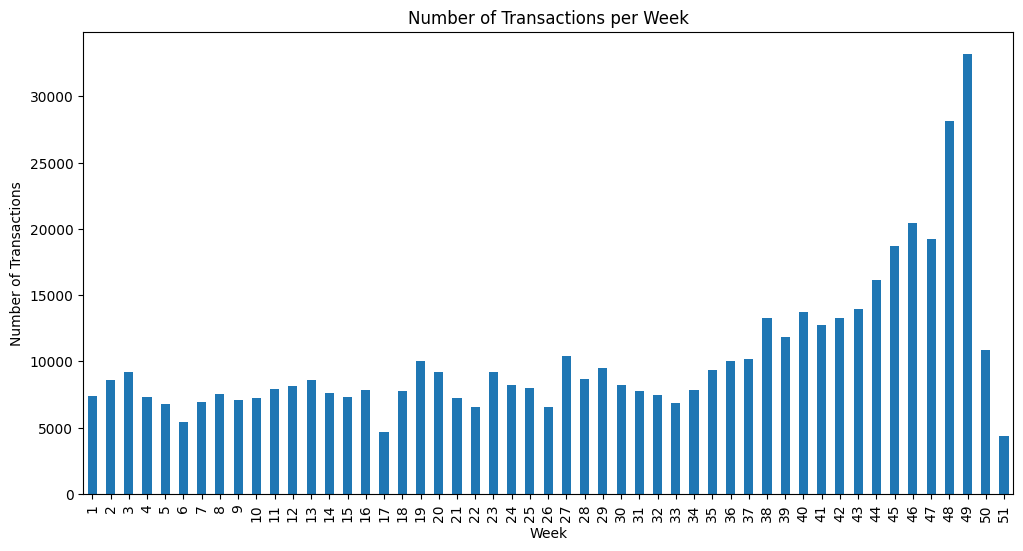

In [ ]:
# Plot du nombre de transaction par semaine

df1['Week'].value_counts().sort_index()

# Plot the value counts of the 'Week' column
week_counts = df1['Week'].value_counts().sort_index()
week_counts.plot(kind='bar', figsize=(12, 6))

plt.xlabel('Week')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Week')
plt.show()

On voit bien que les fêtes de fin d'année boostent énormément les ventes, a contrario, aux environs du carême/pâques pour les chrétiens, il y a beaucoup moins de vente (17ème semaine environ 26 avril)

C:\Users\adrib\AppData\Local\Temp\ipykernel_58860\75906562.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_sales = df1.groupby('Week').apply(lambda x: (x['UnitPrice'] * x['Quantity']).sum())


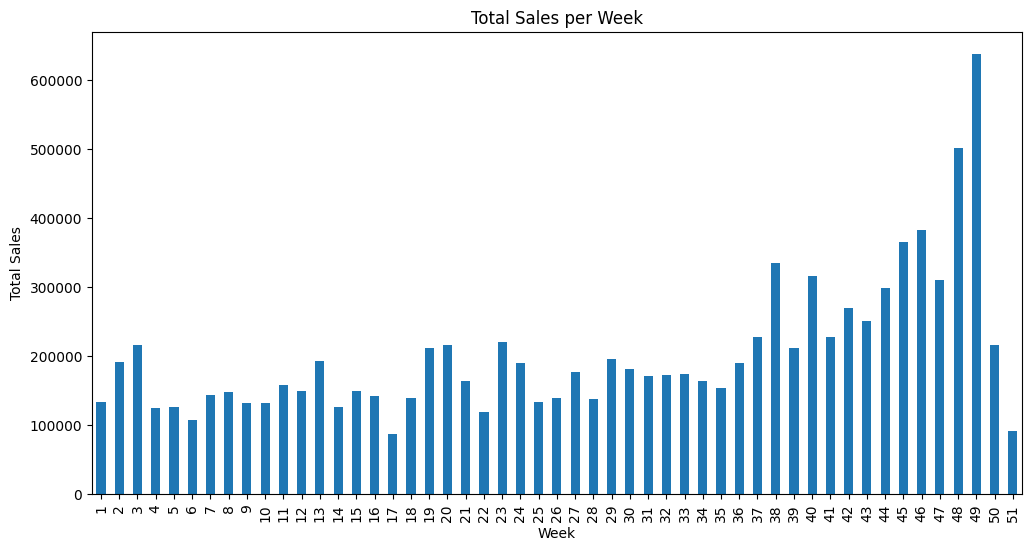

In [ ]:
# Plot de la valeur totale des ventes par semaine (donc on multiplie la quantité par le prix unitaire)

weekly_sales = df1.groupby('Week').apply(lambda x: (x['UnitPrice'] * x['Quantity']).sum())

weekly_sales.plot(kind='bar', figsize=(12, 6))

plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.title('Total Sales per Week')
plt.show()

C:\Users\adrib\AppData\Local\Temp\ipykernel_58860\3124859939.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_sales = df1.groupby('Month').apply(lambda x: (x['UnitPrice'] * x['Quantity']).sum())


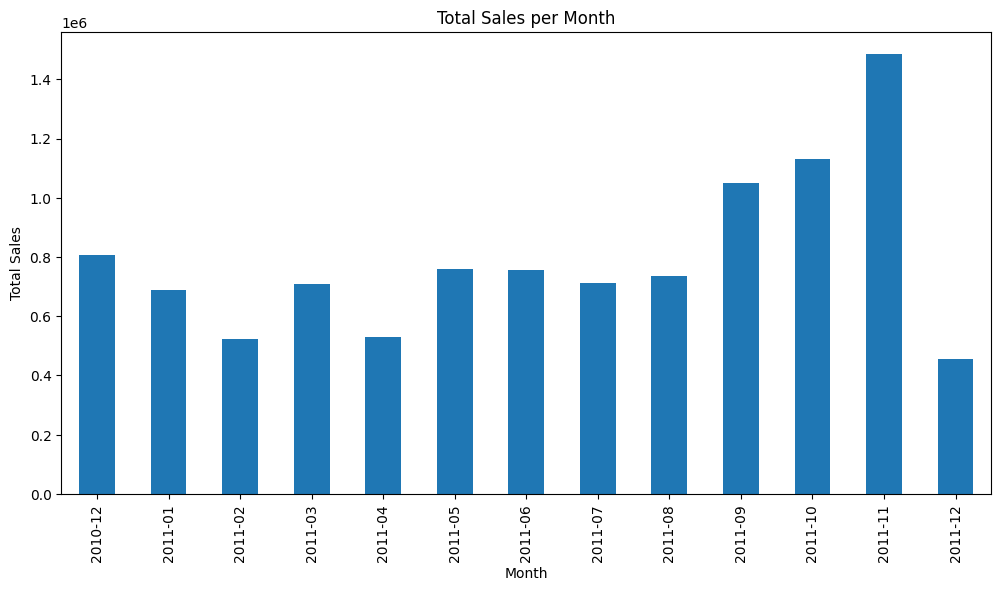

In [ ]:
# Plot de la valeur totale des ventes par mois (donc on multiplie la quantité par le prix unitaire)

monthly_sales = df1.groupby('Month').apply(lambda x: (x['UnitPrice'] * x['Quantity']).sum())

monthly_sales.plot(kind='bar', figsize=(12, 6))

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales per Month')
plt.show()

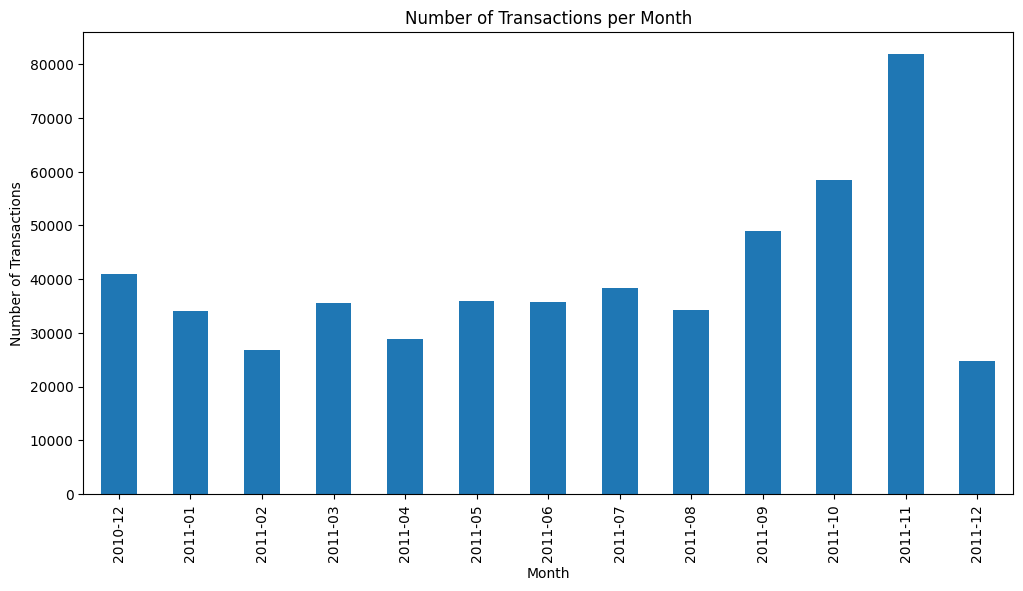

In [217]:
# Plot du nombre de transaction par mois
df1['Month'].value_counts().sort_index()

# Plot the value counts of the 'Month' column
month_counts = df1['Month'].value_counts().sort_index()
month_counts.plot(kind='bar', figsize=(12, 6))

plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per Month')
plt.show()

In [115]:
total_command = df1.groupby('CustomerID')['InvoiceNo'].nunique()
total_command = total_command[total_command > 20].sort_values(ascending=False)

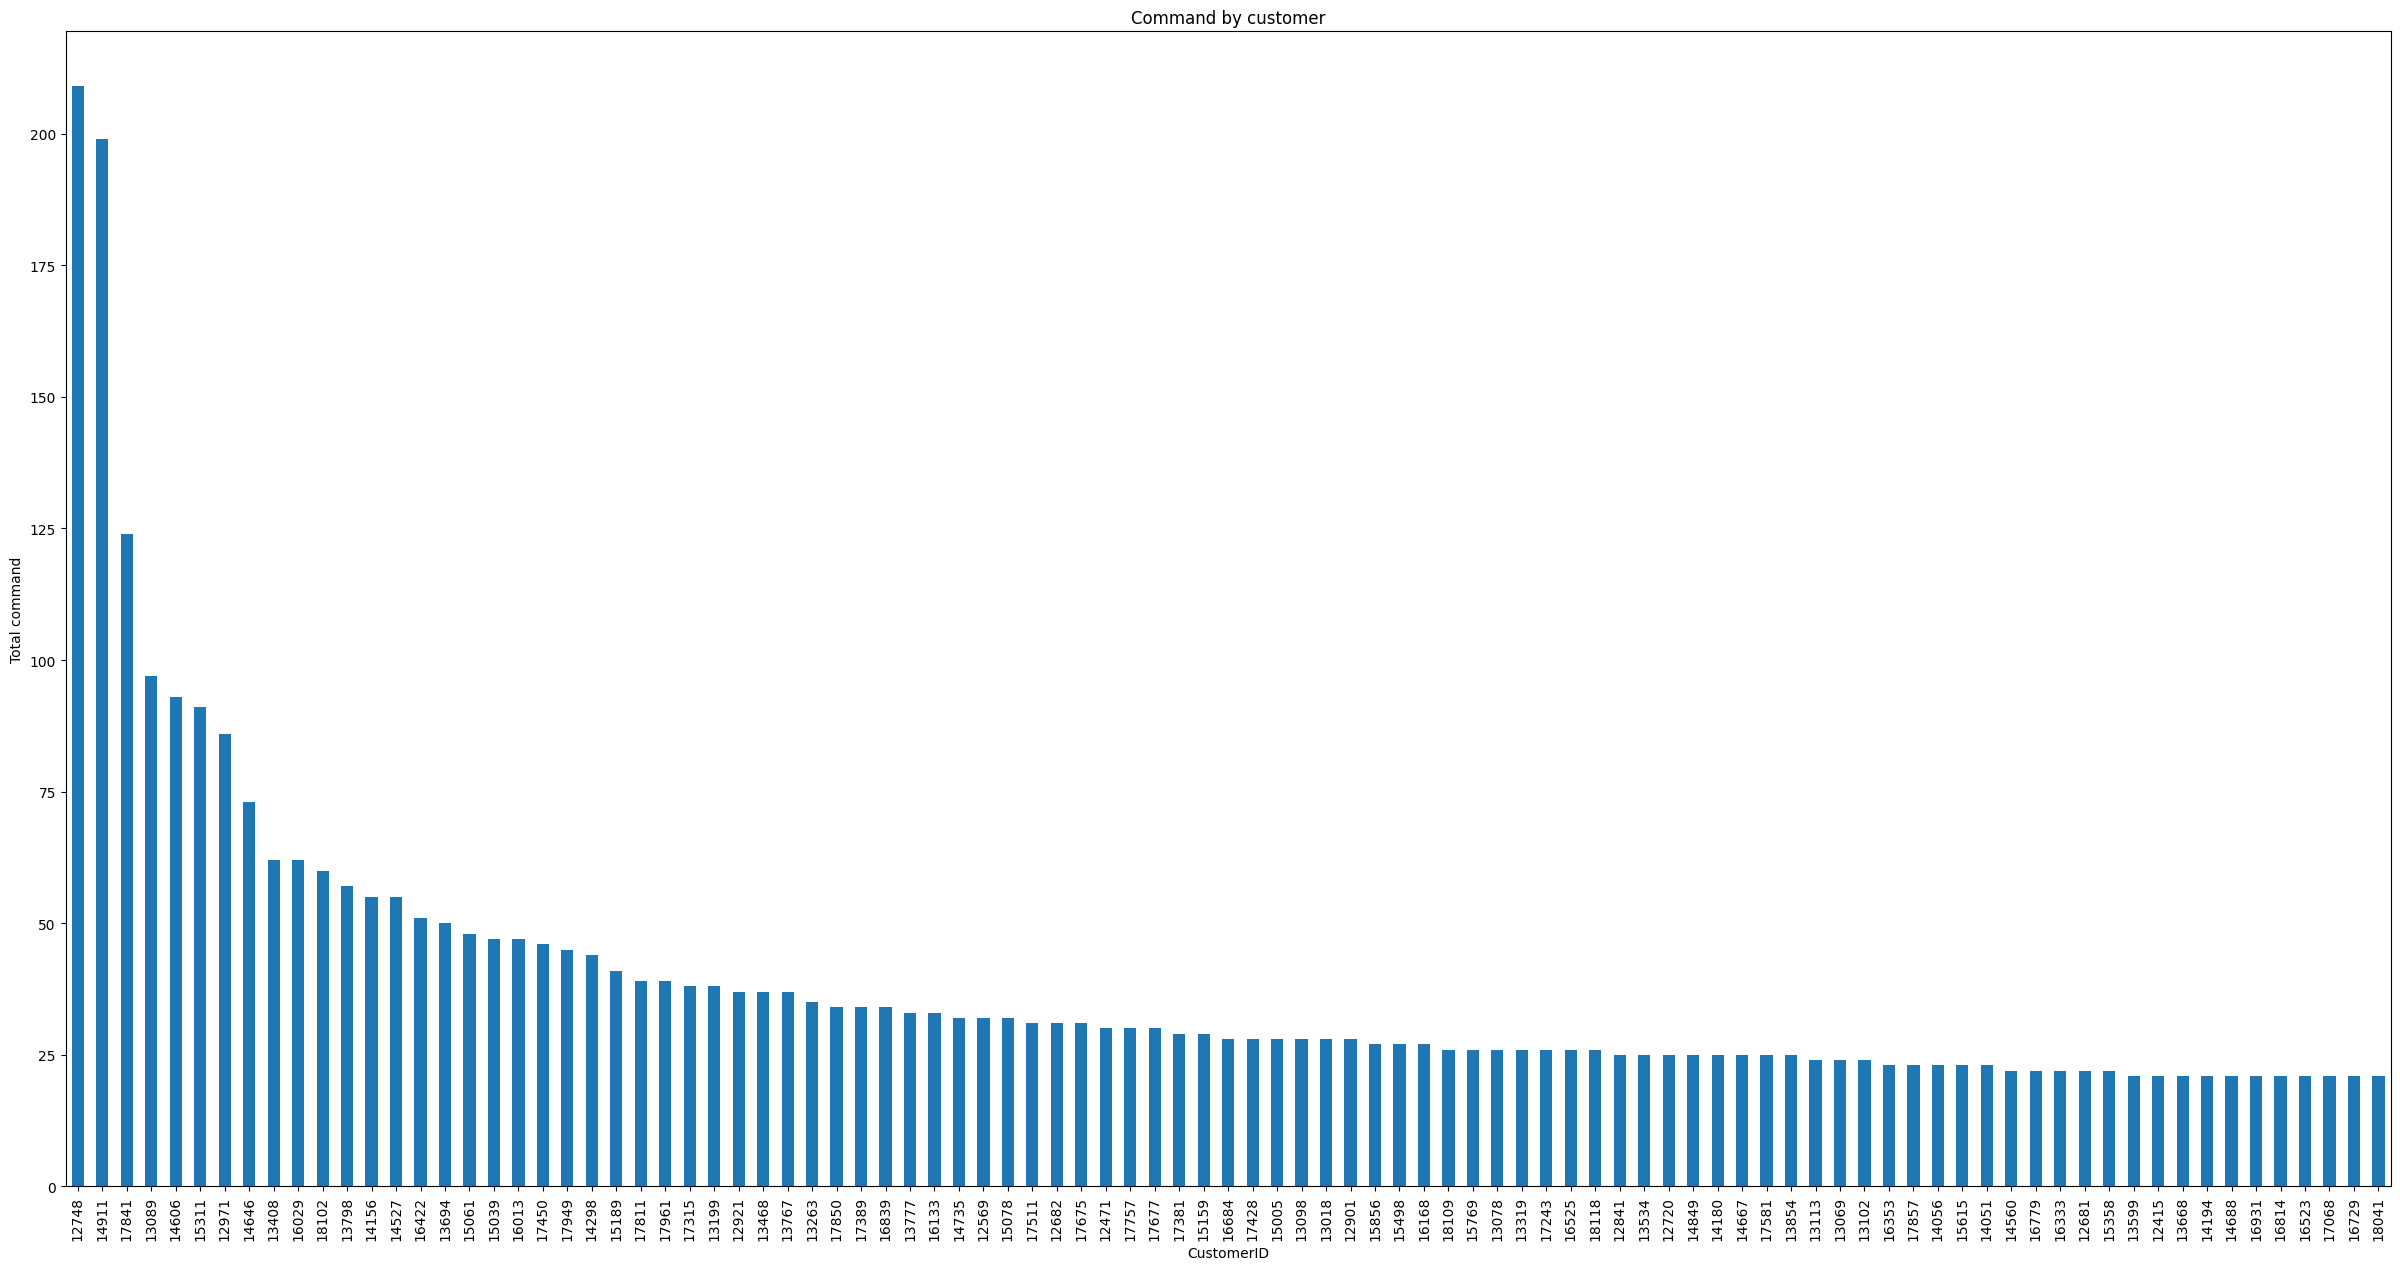

In [218]:
# Plot du nombre de commandes par client (seulement ceux à plus de 20 commandes)

total_command_sauf=total_command[1:]
total_command_sauf.plot(kind='bar', figsize=(30, 15))

plt.xlabel('CustomerID')
plt.ylabel('Total command')
plt.title('Command by customer')
plt.show()

## Implémentation de modèles
### 1ère approche

In [ ]:
# Création de df2 qui reprend les valeurs de df1 qui nous intéressent pour l'analyse
# Le but de l'analyse est de se savoir si à partir des données 
# tel que la date, le pays, et si oui ou non le client a un id,
# on peut déterminer le montant total d'une commande

df2 = df1.groupby(['InvoiceNo']).agg({
    'Total': 'sum',
    #'InvoiceDate': 'first',
    #'Country': 'first',
    #'Hour': 'first',
    'Day': 'first',
    'Week': 'first',
    'Month': 'first',
    'CustomerID': 'first'
}).reset_index()
df2

,InvoiceNo,Total,Week,Month,CustomerID
0,536365,139.12,48,2010-12,True
1,536366,22.20,48,2010-12,True
2,536367,278.73,48,2010-12,True
3,536368,70.05,48,2010-12,True
4,536369,17.85,48,2010-12,True
...,...,...,...,...,...
19927,581583,124.60,49,2011-12,True
19928,581584,140.64,49,2011-12,True
19929,581585,329.05,49,2011-12,True
19930,581586,339.20,49,2011-12,True


In [ ]:
# Pour cela il faut adapter les colonnes country et customerID pour les rendre utilisables (OneHot)

df_encoded = pd.get_dummies(df2, columns=['Country', 'CustomerID'], drop_first=True)

In [ ]:
# Séparation des données entre les caractéristiques (X) et la variable cible (y)

X = df_encoded.drop(columns=['Total'])
y = df_encoded['Total']

# On divise les données en ensemble d'entraînement et de test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)


Taille de l'ensemble d'entraînement : (15945, 4)
Taille de l'ensemble de test : (3987, 4)


In [ ]:
# Convertir les colonnes de type 'Timestamp' en valeurs numériques
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Imputer les valeurs manquantes avec la moyenne de chaque colonne
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE) :", mse)
print("Mean Absolute Error (MAE) :", mae)


Mean Squared Error (MSE) : 3074900.9625864136
Mean Absolute Error (MAE) : 443.3635541401977


C:\Users\adrib\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Month']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\adrib\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Month']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
# Initialiser le modèle de forêt aléatoire
rf_model = RandomForestRegressor(random_state=42)

# Définir une grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Utiliser le meilleur modèle trouvé pour faire des prédictions sur l'ensemble de test
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Évaluer les performances du modèle optimisé
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Mean Squared Error (MSE) après optimisation :", mse_rf)
print("Mean Absolute Error (MAE) après optimisation :", mae_rf)


Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Mean Squared Error (MSE) après optimisation : 3086563.4810891007
Mean Absolute Error (MAE) après optimisation : 442.7933310244797


L'analyse réalisée n'est pas très concluante, les valeurs de MSE et MAE sont très très élevées, 
en effet le MSE punit lourdement les grosses erreurs d'où un score en milion
et le MAE de 442 est très mauvais par rapport à des prix avoisinant au maximum les 50€

Je pense qu'ici le modèle n'est pas à mettre en cause, mais les données utilisées pour prédir le prix, la présence ou non d'un customerID (à savoir que les prix semblement plus cher chez les clients sans customerID d'où l'emploie de cette colonne) et les informations temporelles & spatiales ne permettent pas d'avoir une indication précise sur le montant de la commande réalisée.

## 2e approche : Prediction du revenu à partir de la description du produit (appliquée à l'exemple de l'Allemagne)
Nous allons ici utiliser la regression linéaire pour prédire le revenu à partir de la description du produit. Nous allons pour cela utiliser plusieurs modèles.
On utilise un embedding car on veut exprimer les descriptions de manière vectorielle afin de pouvoir utiliser la regression
on utilise une transformation de string avec


Dans un premier temps, la Regression Linéaire

In [21]:
#Filtre pour n'avoir que les produits vendus en Allemagne
df1['Revenue'] = df1['UnitPrice']*df1['Quantity']
df_1 = df1[df1['Country'] == 'Germany']

#Implementation de l'embedding à partir des descriptions du jeu de données
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = sentence_model.encode(df_1['Description'].tolist(), show_progress_bar=True)
y = df_1['Revenue']
#Split 80-20
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialisation du modèle
model = LinearRegression(fit_intercept=True)

# Entrainement du modele sur les données d'entrainement
model.fit(X_train_scaled, y_train)

# Prediction sur l'entrainement et le test
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Metriques
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Prediction sur tout le test
y_pred = model.predict(X_test)

# Evaluation de la performance
mae_test = mean_absolute_error(y_test, y_pred)


Batches:   0%|          | 0/283 [00:00<?, ?it/s]

In [22]:
print("Train Mean Squared Error (MSE) :", mse_train)
print("Test Mean Squared Error (MSE) :", mse_test)
print("Test Mean Absolute Error (MSE) :", mae_test)

Train Mean Squared Error (MSE) : 898.7844569068042
Test Mean Squared Error (MSE) : 1405.4885259857206
Test Mean Absolute Error (MSE) : 902.306247804721


Ensuite, pour le modele RandomForestRegressor

In [25]:
# Initialisation du modèle
model = RandomForestRegressor(n_estimators=10, max_depth=3, min_samples_split=2, min_samples_leaf=1)

# Entrainement du modele sur les données d'entrainement
model.fit(X_train_scaled, y_train)

# Prediction sur l'entrainement et le test
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Metriques
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Prediction sur tout le test
y_pred = model.predict(X_test)

# Evaluation de la performance
mae_test = mean_absolute_error(y_test, y_pred)

In [26]:
print("Train Mean Squared Error (MSE) :", mse_train)
print("Test Mean Squared Error (MSE) :", mse_test)
print("Test Mean Absolute Error (MSE) :", mae_test)

Train Mean Squared Error (MSE) : 939.4166751553395
Test Mean Squared Error (MSE) : 1388.7478066167291
Test Mean Absolute Error (MSE) : 16.193541031243456


Ensuite, pour le modèle SVR

In [ ]:
# Initialisation du modèle
model = SVR(C=1.0, kernel='linear', epsilon=0.1)

# Entrainement du modele sur les données d'entrainement
model.fit(X_train_scaled, y_train)

# Prediction sur l'entrainement et le test
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Metriques
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Prediction sur tout le test
y_pred = model.predict(X_test)

# Evaluation de la performance
mae_test = mean_absolute_error(y_test, y_pred)

In [ ]:
print("Train Mean Squared Error (MSE) :", mse_train)
print("Test Mean Squared Error (MSE) :", mse_test)
print("Test Mean Absolute Error (MSE) :", mae_test)

Pour le modele K-NeighborsRegressor

In [ ]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialisation du modèle
model = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto')

# Entrainement du modele sur les données d'entrainement
model.fit(X_train_scaled, y_train)

# Prediction sur l'entrainement et le test
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Metriques
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Prediction sur tout le test
y_pred = model.predict(X_test)

# Evaluation de la performance
mae_test = mean_absolute_error(y_test, y_pred)

In [ ]:
print("Train Mean Squared Error (MSE) :", mse_train)
print("Test Mean Squared Error (MSE) :", mse_test)
print("Test Mean Absolute Error (MSE) :", mae_test)

On voit un overfit assez présent pour chaque modèle, on le voit avec la difference entre les mse_train et le mse_test
L'underfit est également présent pour le SVR car la veur du MSE_train est elevée
Lorsque l'on effectue la même approche pour les descriptions communes (Attribut CommonDescription), on se rend compte que les résultats sont exactement les mêmes.